In [1]:
import os
import random
import easydict
import requests
import torch
import numpy as np
import pandas as pd

from tqdm import tqdm
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## func

### generate_data_loader

In [2]:
def generate_data_loader(file_path, tokenizer, args):

    def get_input_ids(data):
        document_bert = ["[CLS] " + str(s) + " [SEP]" for s in data]
        tokenized_texts = [tokenizer.tokenize(s) for s in tqdm(document_bert, "Tokenizing")]
        input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_texts, "Converting tokens to ids")]
        print("Padding sequences...")
        input_ids = pad_sequences(input_ids, maxlen=args.maxlen, dtype='long', truncating='post', padding='post')
        return input_ids

    def get_attention_masks(input_ids):
        attention_masks = []
        for seq in tqdm(input_ids, "Generating attention masks"):
            seq_mask = [float(i > 0) for i in seq]
            attention_masks.append(seq_mask)
        return attention_masks

    def get_data_loader(inputs, masks, labels, batch_size=args.batch):
        data = TensorDataset(torch.tensor(inputs), torch.tensor(masks), torch.tensor(labels))
        sampler = RandomSampler(data) if args.mode == 'train' else SequentialSampler(data)
        data_loader = DataLoader(data, sampler=sampler, batch_size=batch_size)
        return data_loader

    data_df = pd.read_csv(file_path)
    input_ids = get_input_ids(data_df['text'].values)
    attention_masks = get_attention_masks(input_ids)
    data_loader = get_data_loader(input_ids, attention_masks, data_df['label'].values if args.mode=='train' else [-1]*len(data_df))

    return data_loader

### save&flat_accuracy

In [3]:
def save(model, dir_name):
    os.makedirs(dir_name, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(dir_name, 'model.pth'))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

### predict

In [4]:
def predict(model, args, data_loader):
    print('start predict')
    model.eval()

    eval_loss = []
    eval_accuracy = []
    logits = []

    for step, batch in tqdm(enumerate(data_loader)):
        batch = tuple(t.to(args.device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            if args.mode == 'test':
                outputs = model(b_input_ids, attention_mask=b_input_mask)
                logit = outputs[0]
            else:
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                loss, logit = outputs[:2]
                eval_loss.append(loss.item())

        logit = logit.detach().cpu().numpy()
        label = b_labels.cpu().numpy()

        logits.append(logit)

        if args.mode != 'test':
            accuracy = flat_accuracy(logit, label)
            eval_accuracy.append(accuracy)

    logits = np.vstack(logits)
    predict_labels = np.argmax(logits, axis=1)

    if args.mode == 'test':
        return predict_labels, None

    avg_eval_loss = np.mean(eval_loss)
    avg_eval_accuracy = np.mean(eval_accuracy)

    return predict_labels, avg_eval_loss, avg_eval_accuracy

### train

In [5]:
def train(model, args, train_loader, valid_loader, patience=5):
    experiment_name = f"model_ckpt_{args.model_ckpt.replace('/', '_')}_lr_{args.lr}_batch_{args.batch}_epochs_{args.epochs}_maxlen_{args.maxlen}_eps_{args.eps}"
    writer = SummaryWriter(f'hai_kaggle/{experiment_name}')

    optimizer = AdamW(model.parameters(),
                      lr=args.lr,
                      eps=args.eps
                      )
    total_steps = len(train_loader) * args.epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)

    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    best_val_accuracy = 0.0
    best_train_accuracy = 0.0
    epochs_without_improvement = 0

    train_accuracies = []
    val_accuracies = []

    print('start training')
    for epoch in range(args.epochs):
        model.train()
        train_loss = []
        for step, batch in tqdm(enumerate(train_loader), f"training epoch {epoch}", total=len(train_loader)):
            model.zero_grad()
            batch = tuple(t.to(args.device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            loss = outputs[0]
            train_loss.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            writer.add_scalar('training loss',
                            loss.item(),
                            epoch * len(train_loader) + step)

        avg_train_loss = np.mean(train_loss)
        _, _, avg_train_accuracy = predict(model, args, train_loader)
        _, _, avg_val_accuracy = predict(model, args, valid_loader)
        print("Epoch {0},  Average training loss: {1:.4f} , Train accuracy : {2:.4f}, Validation accuracy : {3:.4f}"
              .format(epoch, avg_train_loss, avg_train_accuracy, avg_val_accuracy))

        train_accuracies.append(avg_train_accuracy)
        val_accuracies.append(avg_val_accuracy)

        writer.add_scalar('training accuracy',
                        avg_train_accuracy,
                        epoch)
        writer.add_scalar('validation accuracy',
                        avg_val_accuracy,
                        epoch)

        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            best_train_accuracy = avg_train_accuracy
            epochs_without_improvement = 0
            save_path = f"./saved_checkpoints/best_model/{experiment_name}_TrainAcc_{best_train_accuracy}_ValAcc_{best_val_accuracy}"
            save(model, save_path)
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"[Early Stopping]{patience} epoch에서 중단.[Early Stopping]")
            break

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epoch + 2), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    model_path = f"./saved_checkpoints/best_model/{experiment_name}_TrainAcc_{best_train_accuracy}_ValAcc_{best_val_accuracy}/model.pth"
    model.load_state_dict(torch.load(model_path))

    print(f"Best Train Accuracy: {best_train_accuracy}, Best Validation Accuracy: {best_val_accuracy}")

    writer.add_hparams({
        'lr': args.lr,
        'eps': args.eps,
        'batch': args.batch,
        'epochs': args.epochs,
        'maxlen': args.maxlen
        }, {
        'best_train_accuracy': best_train_accuracy,
        'best_val_accuracy': best_val_accuracy
        })

    writer.close()
    return model, best_train_accuracy, best_val_accuracy, train_accuracies, val_accuracies

### train_valid

In [6]:
def train_valid(args):
    if torch.cuda.is_available():
        args.device = 'cuda'
    else:
        args.device = 'cpu'

    model = AutoModelForSequenceClassification.from_pretrained(args.model_ckpt, num_labels=3)
    model.to(args.device)
    tokenizer = AutoTokenizer.from_pretrained(args.model_ckpt)

    train_dataloader = generate_data_loader(args.train_path, tokenizer, args)
    validation_dataloader = generate_data_loader(args.valid_path, tokenizer, args)

    model, best_train_accuracy, best_val_accuracy, train_accuracies, val_accuracies = train(model, args, train_dataloader, validation_dataloader)

    return model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy

### test

In [7]:
# best_train_accuracy & best_val_accuracy는 모델 경로 때문에 주는 것임!
def test(model, tokenizer, test_args, file_path, args, best_train_accuracy, best_val_accuracy):
    if torch.cuda.is_available():
        test_args.device = 'cuda'

    test_dataloader = generate_data_loader(file_path, tokenizer=tokenizer, args=test_args)
    labels, _ = predict(model, test_args, test_dataloader)

    submit_df = pd.DataFrame()
    submit_df["idx"] = range(len(labels))
    submit_df["label"] = labels
    save_path = f"./saved_checkpoints/best_model/model_ckpt_{args.model_ckpt.replace('/', '_')}_lr_{args.lr}_batch_{args.batch}_epochs_{args.epochs}_maxlen_{args.maxlen}_eps_{args.eps}_TrainAcc_{best_train_accuracy}_ValAcc_{best_val_accuracy}/submission.csv"
    submit_df.to_csv(save_path, index=False)
    print(f"Submission file saved to {save_path}")

# 파라미터 조정 및 모델 변경

## funnel-kor-base

### 64/32/8.00E-05/1.00E-08/50

Some weights of FunnelForSequenceClassification were not initialized from the model checkpoint at kykim/funnel-kor-base and are newly initialized: ['classifier.linear_out.weight', 'classifier.linear_out.bias', 'classifier.linear_hidden.weight', 'classifier.linear_hidden.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Converting tokens to ids: 100%|█████| 190740/190740 [00:00<00:00, 191603.06it/s]


Padding sequences...


Converting tokens to ids: 100%|███████████| 973/973 [00:00<00:00, 233911.72it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 973/973 [00:00<00:00, 145279.90it/s]


start training


training epoch 0: 100%|█████████████████████| 2981/2981 [09:57<00:00,  4.99it/s]


start predict


2981it [03:04, 16.20it/s]


start predict


16it [00:00, 17.10it/s]


Epoch 0,  Average training loss: 0.9758 , Train accuracy : 0.5793, Validation accuracy : 0.5600


training epoch 1: 100%|█████████████████████| 2981/2981 [09:56<00:00,  5.00it/s]


start predict


2981it [03:03, 16.25it/s]


start predict


16it [00:00, 17.13it/s]


Epoch 1,  Average training loss: 0.9743 , Train accuracy : 0.5793, Validation accuracy : 0.5600


training epoch 2: 100%|█████████████████████| 2981/2981 [09:56<00:00,  5.00it/s]


start predict


2981it [03:03, 16.26it/s]


start predict


16it [00:00, 17.15it/s]


Epoch 2,  Average training loss: 0.9725 , Train accuracy : 0.5794, Validation accuracy : 0.5753


training epoch 3: 100%|█████████████████████| 2981/2981 [09:58<00:00,  4.98it/s]


start predict


2981it [03:05, 16.11it/s]


start predict


16it [00:00, 17.02it/s]


Epoch 3,  Average training loss: 0.9713 , Train accuracy : 0.5793, Validation accuracy : 0.5562


training epoch 4: 100%|█████████████████████| 2981/2981 [10:02<00:00,  4.94it/s]


start predict


2981it [03:05, 16.09it/s]


start predict


16it [00:00, 16.97it/s]


Epoch 4,  Average training loss: 0.9739 , Train accuracy : 0.5793, Validation accuracy : 0.5600


training epoch 5: 100%|█████████████████████| 2981/2981 [10:03<00:00,  4.94it/s]


start predict


2981it [03:05, 16.08it/s]


start predict


16it [00:00, 16.96it/s]


Epoch 5,  Average training loss: 0.9729 , Train accuracy : 0.5793, Validation accuracy : 0.5485


training epoch 6: 100%|█████████████████████| 2981/2981 [10:04<00:00,  4.93it/s]


start predict


2981it [03:05, 16.10it/s]


start predict


16it [00:00, 16.98it/s]


Epoch 6,  Average training loss: 0.9717 , Train accuracy : 0.5793, Validation accuracy : 0.5677


training epoch 7: 100%|█████████████████████| 2981/2981 [10:03<00:00,  4.94it/s]


start predict


2981it [03:04, 16.13it/s]


start predict


16it [00:00, 17.03it/s]


Epoch 7,  Average training loss: 0.9712 , Train accuracy : 0.5793, Validation accuracy : 0.5562
[Early Stopping]5 epoch에서 중단.[Early Stopping]


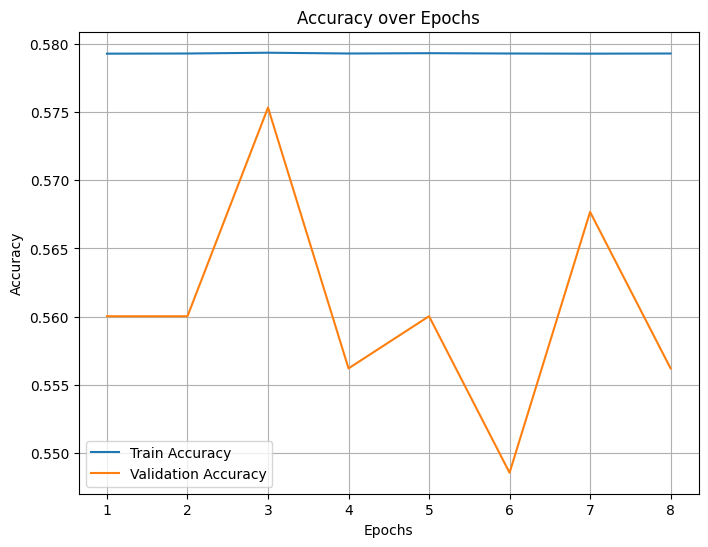

Best Train Accuracy: 0.5793745806776249, Best Validation Accuracy: 0.5753455528846154


Converting tokens to ids: 100%|███████████| 626/626 [00:00<00:00, 215923.87it/s]


Padding sequences...


Generating attention masks: 100%|█████████| 626/626 [00:00<00:00, 168223.62it/s]


start predict


10it [00:00, 16.83it/s]

Submission file saved to ./saved_checkpoints/best_model/model_ckpt_kykim_funnel-kor-base_lr_8e-05_batch_64_epochs_50_maxlen_32_eps_1e-08_TrainAcc_0.5793745806776249_ValAcc_0.5753455528846154/submission.csv


In [8]:
args = easydict.EasyDict({
    "train_path": "./train.csv",
    "valid_path": "./valid.csv",
    "device" : 'cpu',
    "mode" : "train",
    "batch" : 64,
    "maxlen" : 32,
    "lr" : 8e-5,
    "eps" : 1e-8,
    "epochs" : 50,
    "model_ckpt" : "kykim/funnel-kor-base",
})

test_args = easydict.EasyDict({
  "device" : "cpu",
  "mode" : "test",
  "batch" : 64,
  "maxlen" : 32,
})

model, tokenizer, train_accuracies, val_accuracies, best_train_accuracy, best_val_accuracy = train_valid(args)
test(model, tokenizer, test_args, "./test.csv", args, best_train_accuracy, best_val_accuracy)